# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные лежат в папке `/datasets/image_search/`.

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

In [1]:
# загрузка библиотеки методов для анализа данных
!pip install sweetviz
!pip install torchvision

In [2]:
!pip install ipywidgets
!pip install nltk

In [3]:
!jupyter labextension install @jupyter-widgets/jupyterlab-manager

Building jupyterlab assets (production, minimized)


In [4]:
# испорт необходимых библиотек
import pandas as pd
import os
import urllib
from pathlib import Path
import sweetviz as sv
from collections import Counter
from nltk.tokenize import word_tokenize
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
tqdm.pandas()

In [5]:
# создание папки 'datsets' в директории
Path('datasets').mkdir(parents=True, exist_ok=True)

# создание словаря с именем файла и ссылкой на него
urls = {
   'train_dataset': ('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/VPwd3TCR5klqQg',
                  '/Users/razanovaekaterinaandreevna/PycharmProjects/proj/datasets/train_dataset.csv'),
    'test_queries': ('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/X1pH7DRGwzRPbg',
                  '/Users/razanovaekaterinaandreevna/PycharmProjects/proj/datasets/test_queries.csv'),
    'test_images': ('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/0LWvicMlRy0d4Q',
                  '/Users/razanovaekaterinaandreevna/PycharmProjects/proj/datasets/test_images.csv'),
    'CrowdAnnotations': ('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/FP23mw5J71Z6jQ',
                  '/Users/razanovaekaterinaandreevna/PycharmProjects/proj/datasets/CrowdAnnotations.tsv'),
    'ExpertAnnotations': ('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Vgcx78qkm1IUzA',
                  '/Users/razanovaekaterinaandreevna/PycharmProjects/proj/datasets/ExpertAnnotations.tsv')
} 

for url in urls:
# проверка наличия файла 
    if not os.path.exists(urls.get(url)[1]):
        print(urls.get(url)[1], 'файл не найден, будет загружен из сети')
# скачивание файла по ссылке url и размещение файла по пути file_name
        urllib.request.urlretrieve(*urls.get(url))

In [6]:
# чтение загруженных данных
# файлы формата csv
train_dataset = pd.read_csv('/Users/razanovaekaterinaandreevna/PycharmProjects/proj/datasets/train_dataset.csv')
test_queries = pd.read_csv('/Users/razanovaekaterinaandreevna/PycharmProjects/proj/datasets/test_queries.csv', sep='|', index_col=0)
test_images = pd.read_csv('/Users/razanovaekaterinaandreevna/PycharmProjects/proj/datasets/test_images.csv')

# файлы формата tsv
crowd_annotations = pd.read_table('/Users/razanovaekaterinaandreevna/PycharmProjects/proj/datasets/CrowdAnnotations.tsv', header=None)
expert_annotations = pd.read_table('/Users/razanovaekaterinaandreevna/PycharmProjects/proj/datasets/ExpertAnnotations.tsv', header=None)

По очереди просмотрим первые строки датасетов.

In [7]:
#
train_dataset.head()

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

In [8]:
#
test_queries.head()

,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

In [9]:
#
test_images.head()

,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg


Данный датасет пока не кажется информативным, т.к. в папке *test_images* мы имеем изображения, необходимые для тестирование модели и их названия должны совпадать со значениями загруженной таблицы images.

In [10]:
#
crowd_annotations.columns = ['filename', 'image_id', 'text = image, %',
                            'text = image, count', 'text != image, count']
crowd_annotations.head(20)

,filename,image_id,"text = image, %","text = image, count","text != image, count"
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.000000,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.000000,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.000000,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.000000,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.000000,0,3
5,1056338697_4f7d7ce270.jpg,2204550058_2707d92338.jpg#2,0.000000,0,3
6,1056338697_4f7d7ce270.jpg,2224450291_4c133fabe8.jpg#2,0.000000,0,3
7,1056338697_4f7d7ce270.jpg,2248487950_c62d0c81a9.jpg#2,0.333333,1,2
8,1056338697_4f7d7ce270.jpg,2307118114_c258e3a47e.jpg#2,0.000000,0,3
9,1056338697_4f7d7ce270.jpg,2309860995_c2e2a0feeb.jpg#2,0.000000,0,3


В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

In [11]:
#
expert_annotations.columns = ['filename', 'image_id', 'expert1', 'expert2', 'expert3']
expert_annotations.head()

,filename,image_id,expert1,expert2,expert3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке: 

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке. 
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


/Users/razanovaekaterinaandreevna/PycharmProjects/proj/venv/lib/python3.8/site-packages/sweetviz/dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
/Users/razanovaekaterinaandreevna/PycharmProjects/proj/venv/lib/python3.8/site-packages/sweetviz/dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()


                                             |                                                                …

/Users/razanovaekaterinaandreevna/PycharmProjects/proj/venv/lib/python3.8/site-packages/sweetviz/series_analyzer_text.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in to_process.source_counts["value_counts_without_nan"].iteritems():
/Users/razanovaekaterinaandreevna/PycharmProjects/proj/venv/lib/python3.8/site-packages/sweetviz/series_analyzer_text.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in to_process.source_counts["value_counts_without_nan"].iteritems():
/Users/razanovaekaterinaandreevna/PycharmProjects/proj/venv/lib/python3.8/site-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
/Users/razanovaekaterinaandreevna/PycharmProjects/proj/venv/lib/python3.8


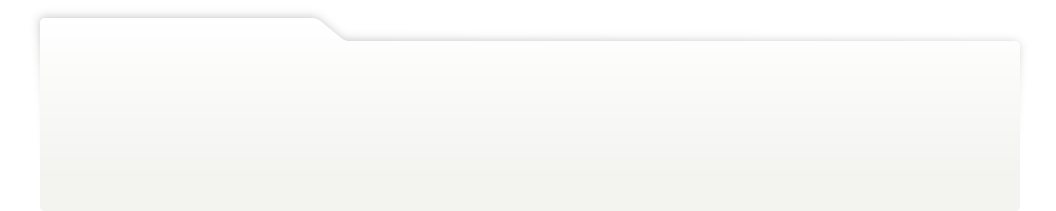
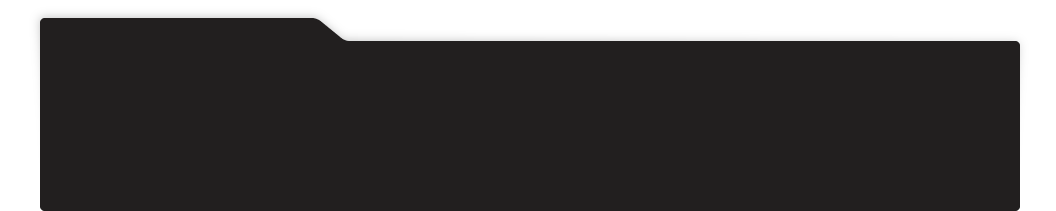
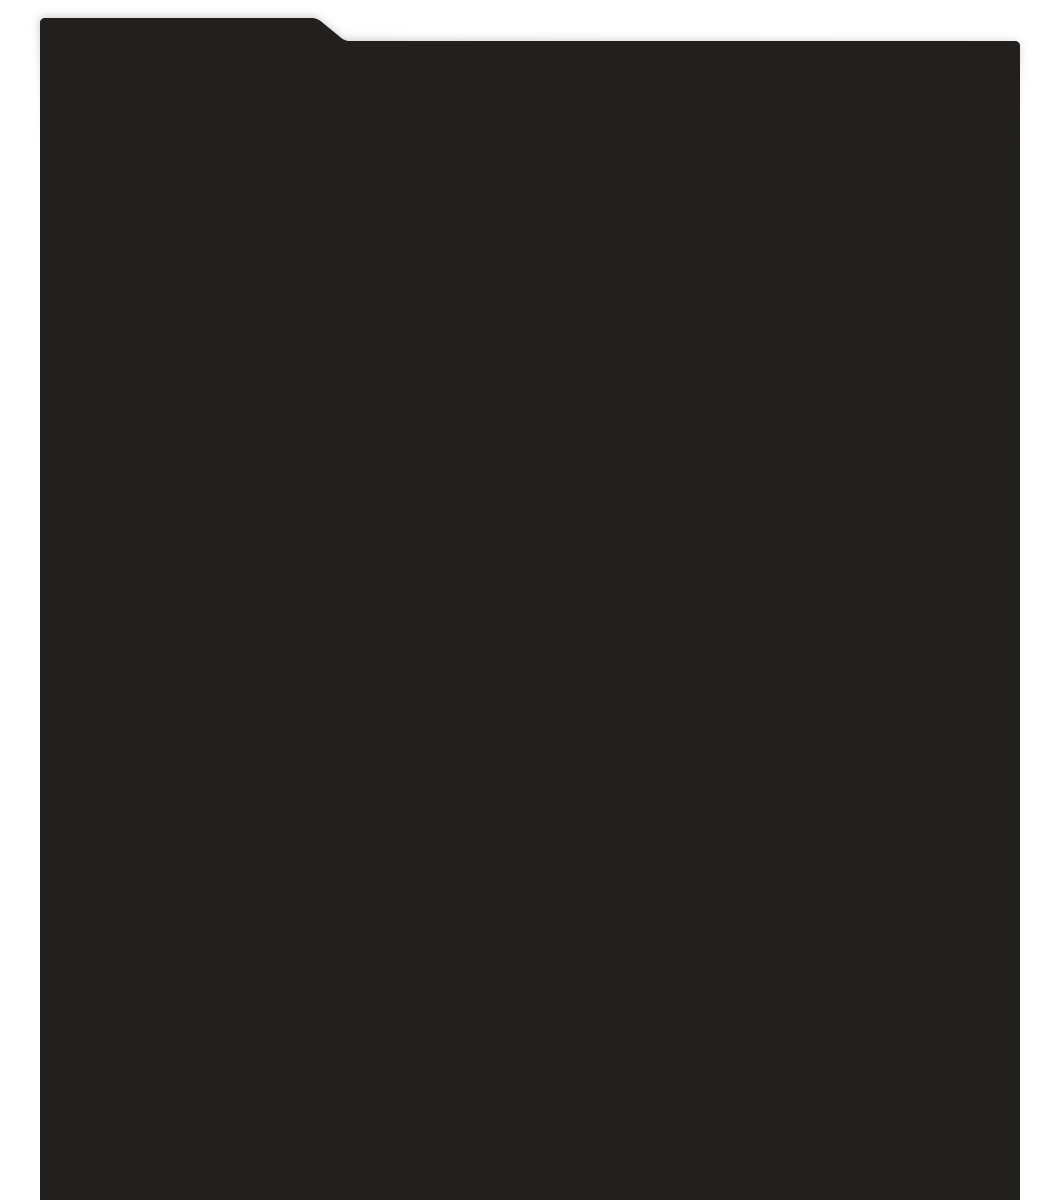
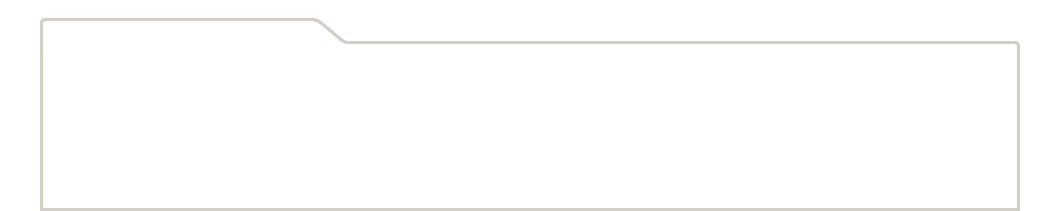
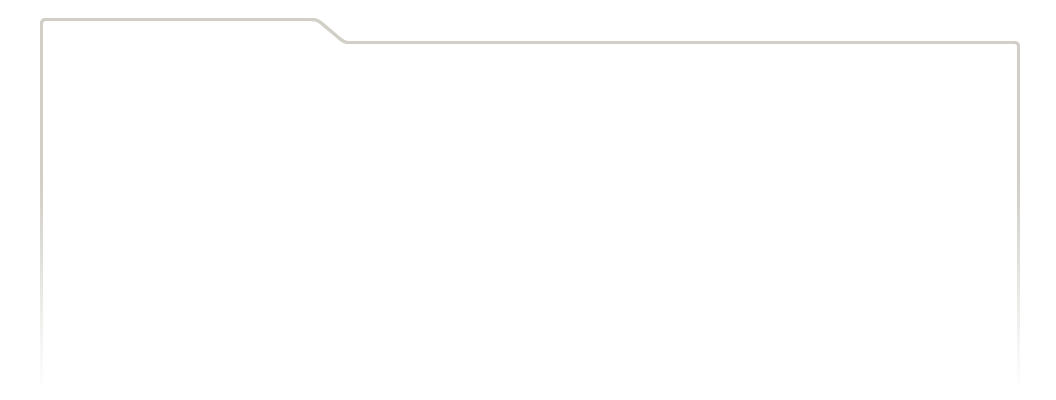
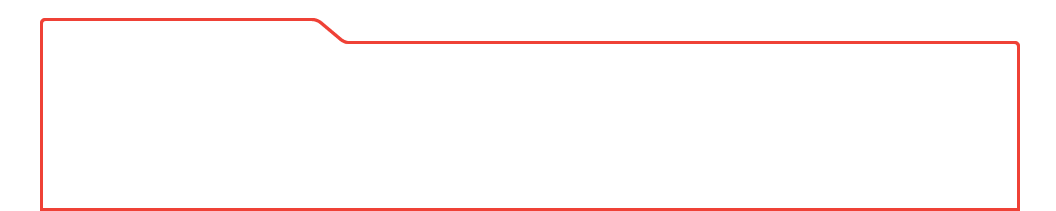
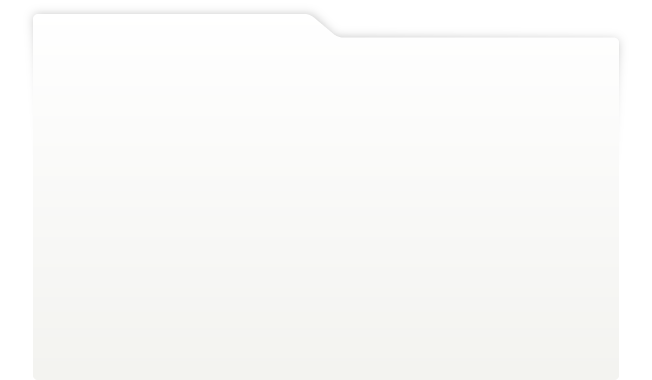
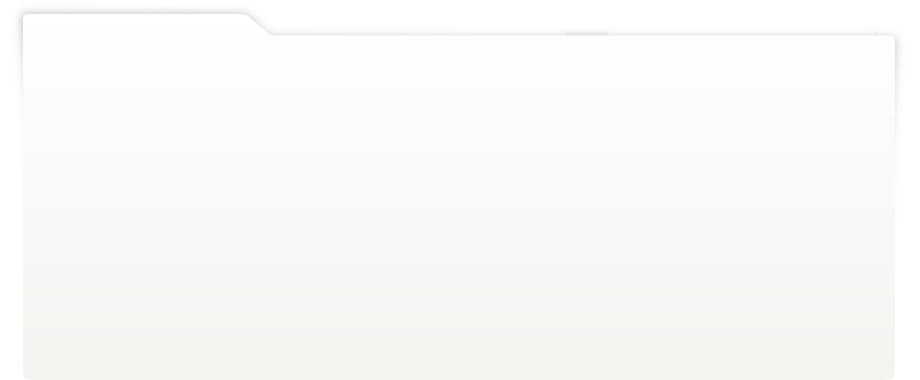
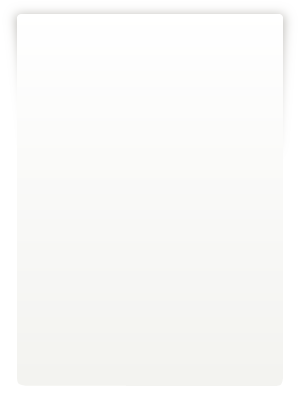
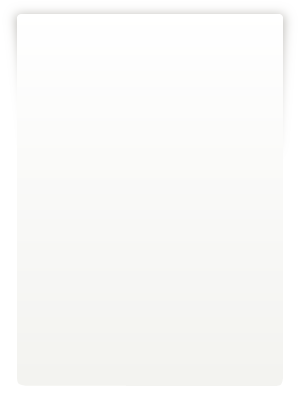
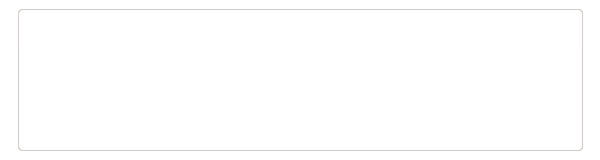
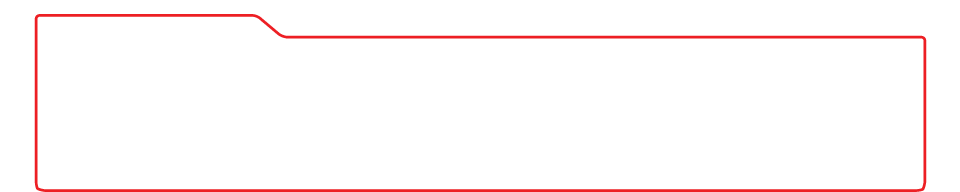
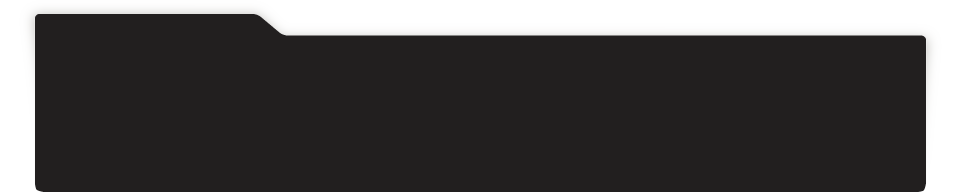
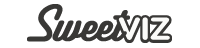
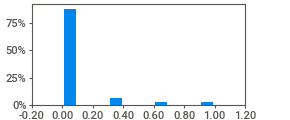
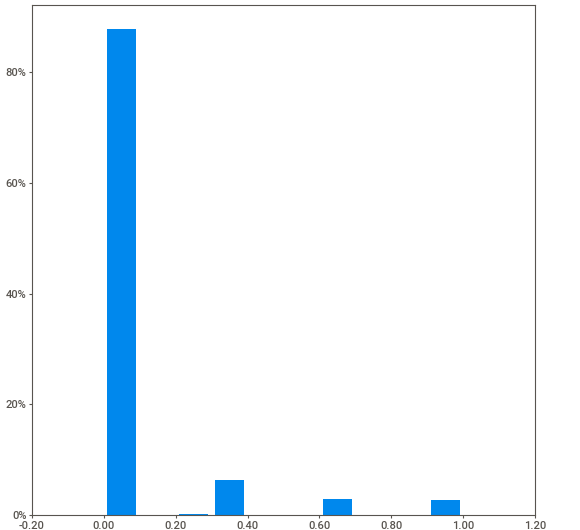
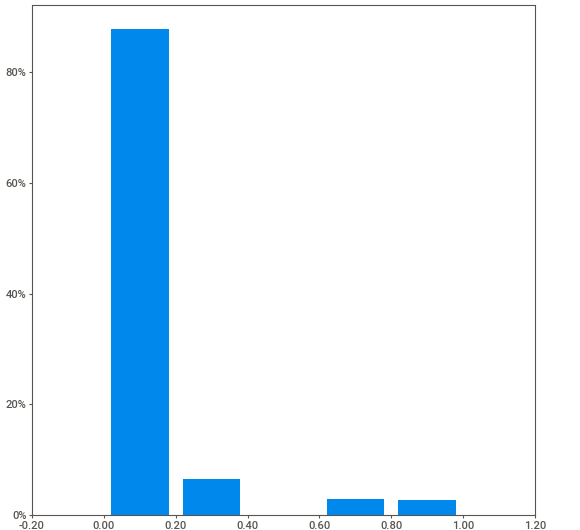
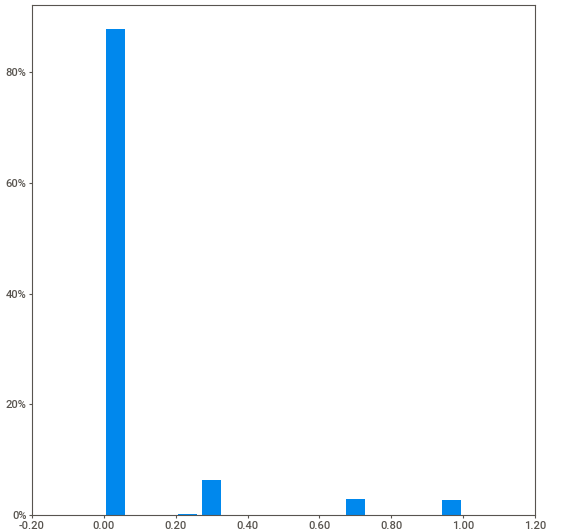
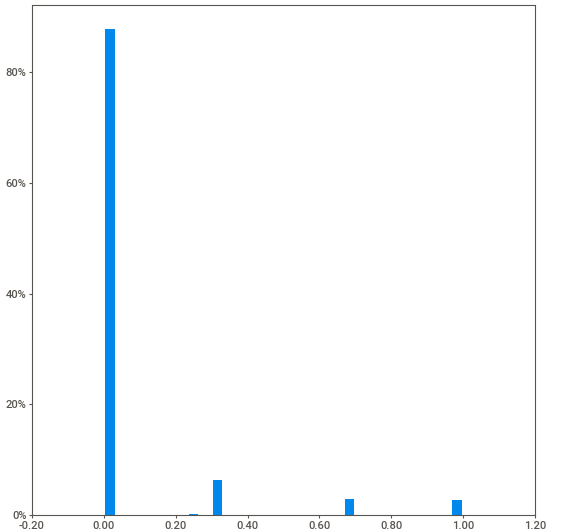
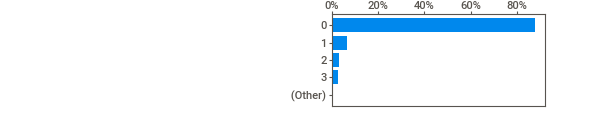
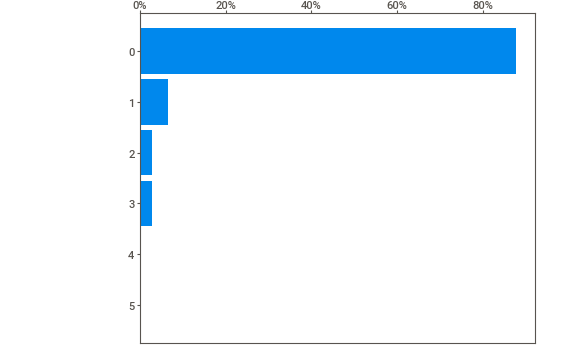
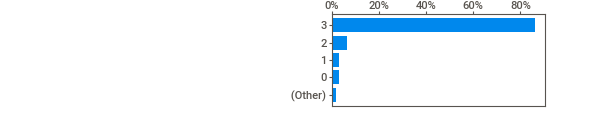
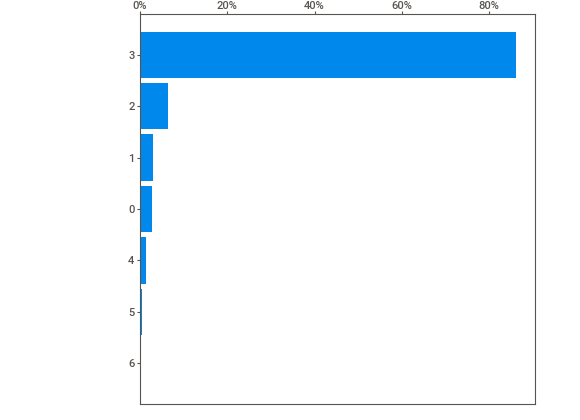
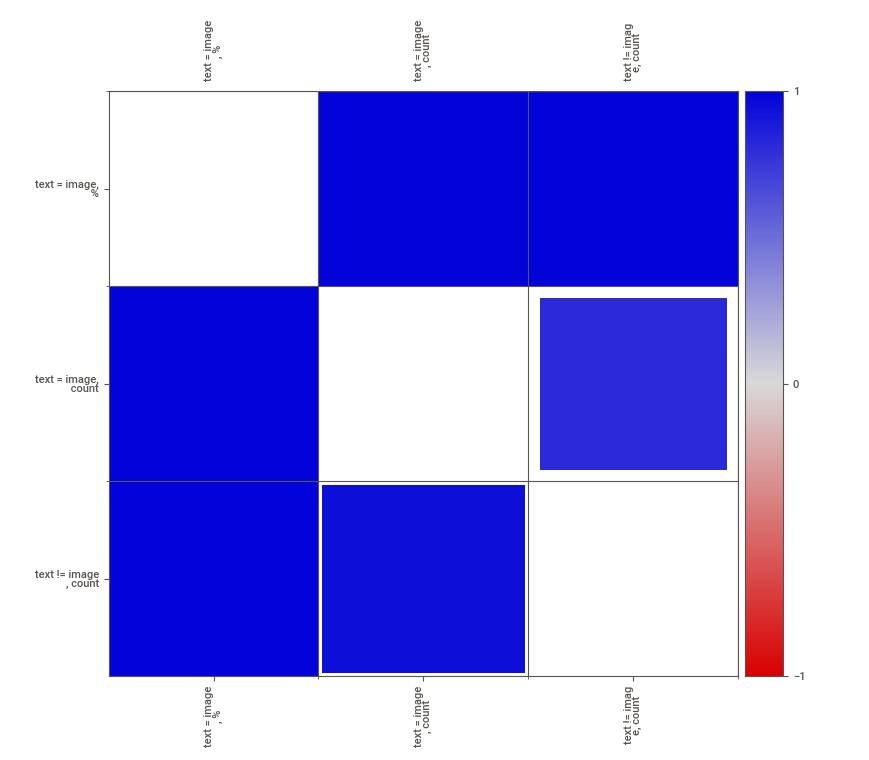
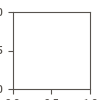

In [12]:
# вывод анализа скважин первого региона
report = sv.analyze([crowd_annotations, 'crowd_annotations'])
report.show_notebook(w=1500, h=500)

/Users/razanovaekaterinaandreevna/PycharmProjects/proj/venv/lib/python3.8/site-packages/sweetviz/dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
/Users/razanovaekaterinaandreevna/PycharmProjects/proj/venv/lib/python3.8/site-packages/sweetviz/dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()


                                             |                                                                …

/Users/razanovaekaterinaandreevna/PycharmProjects/proj/venv/lib/python3.8/site-packages/sweetviz/series_analyzer_text.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in to_process.source_counts["value_counts_without_nan"].iteritems():
/Users/razanovaekaterinaandreevna/PycharmProjects/proj/venv/lib/python3.8/site-packages/sweetviz/series_analyzer_text.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in to_process.source_counts["value_counts_without_nan"].iteritems():
/Users/razanovaekaterinaandreevna/PycharmProjects/proj/venv/lib/python3.8/site-packages/sweetviz/series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
/Users/razanovaekaterinaandreevna/PycharmProjects/proj/venv/lib/python3.8/site-packages/sweetviz/series_analyzer_cat.py:28:


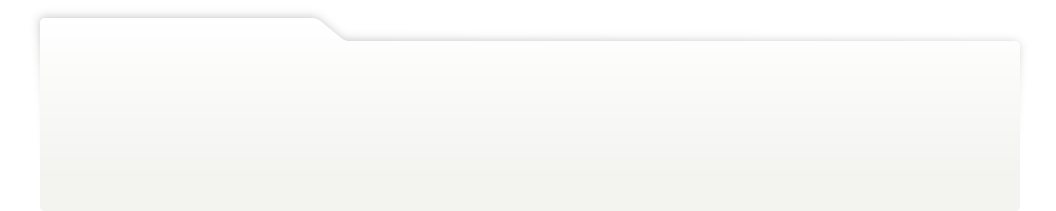
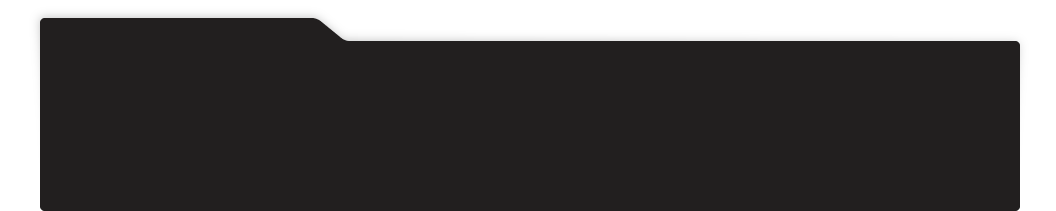
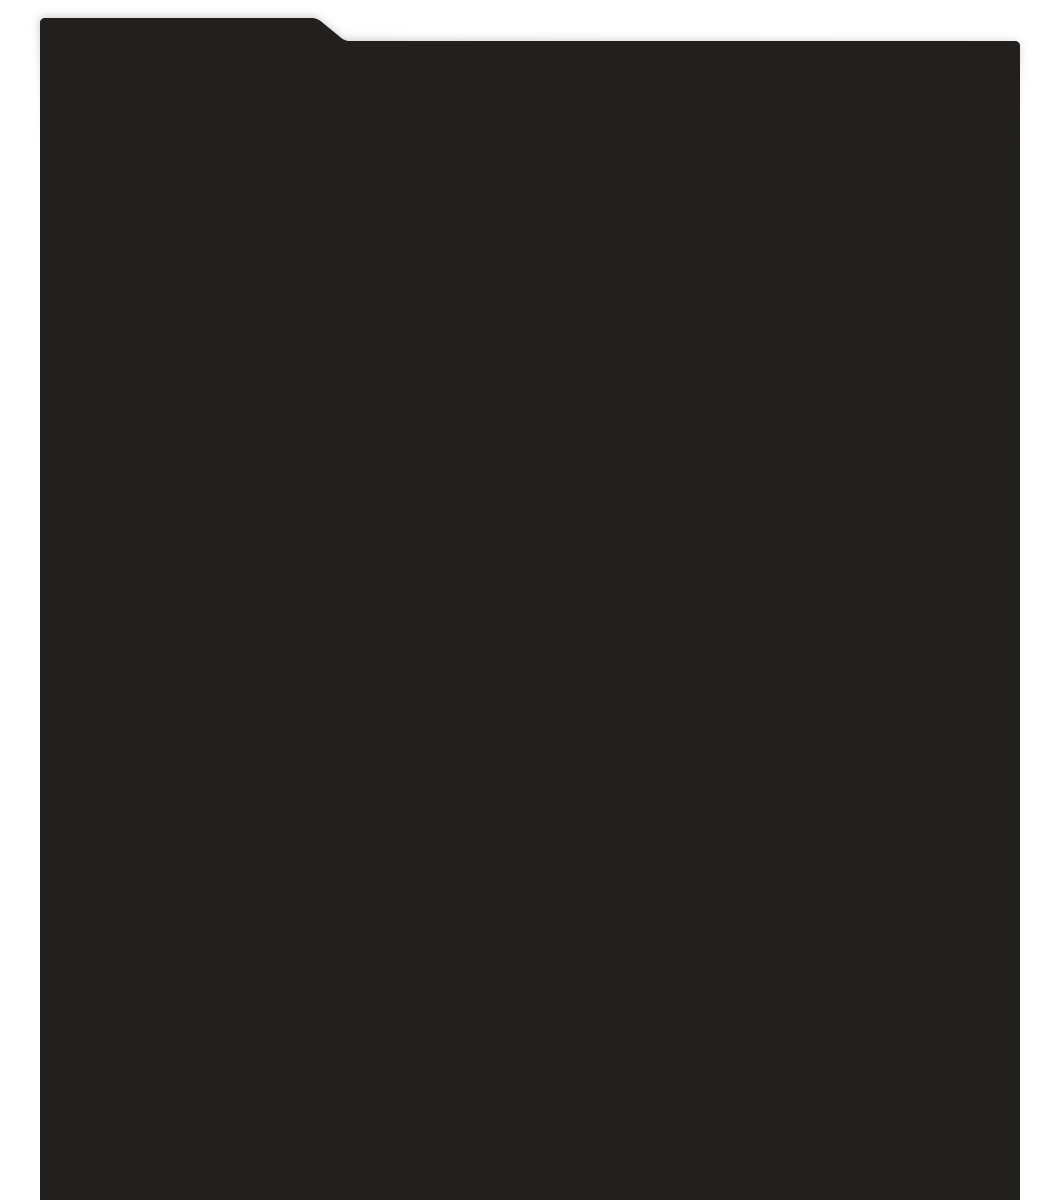
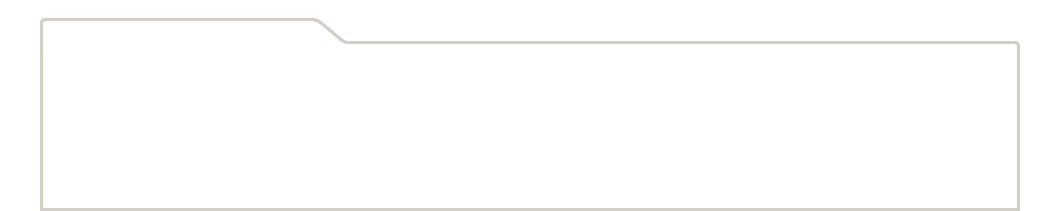
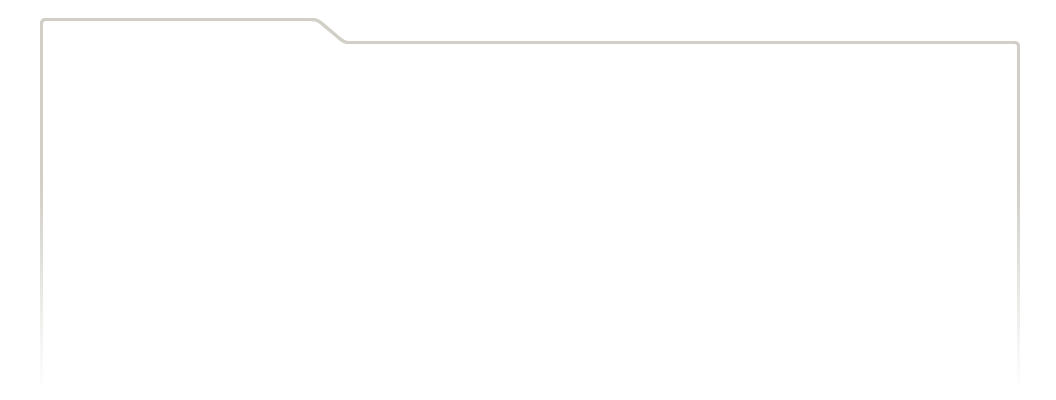
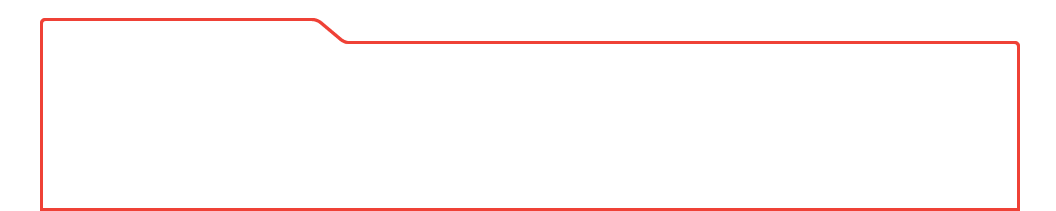
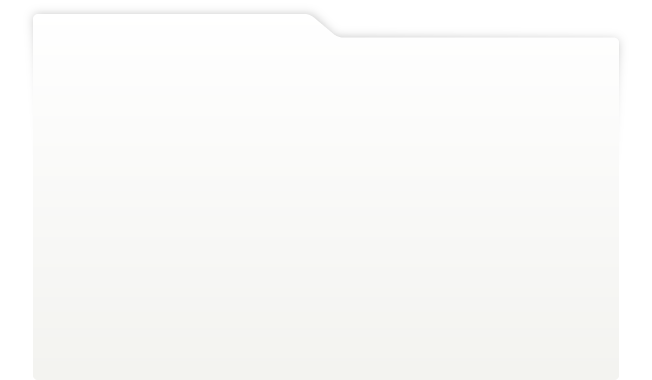
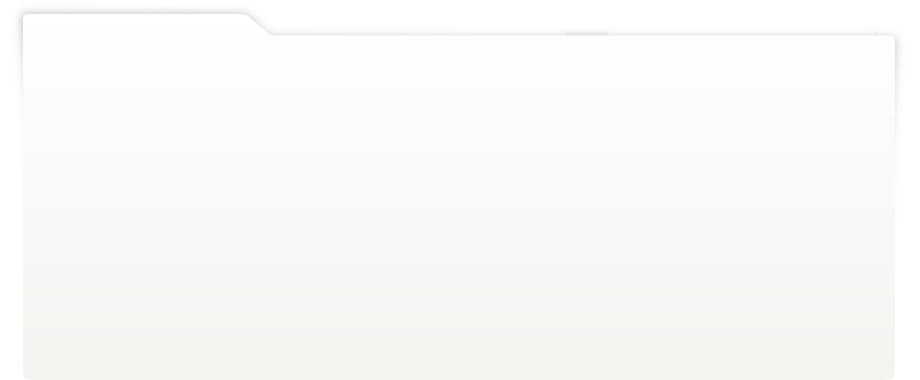
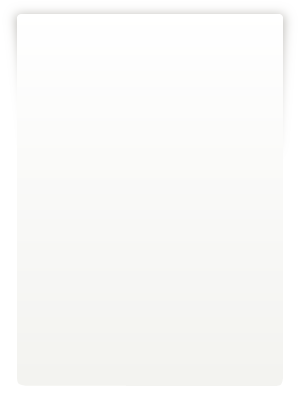
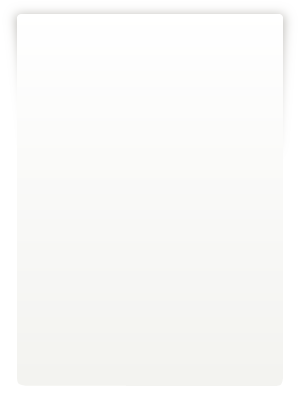
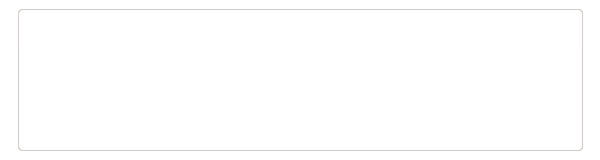
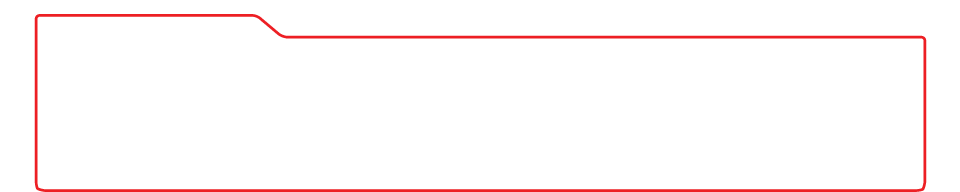
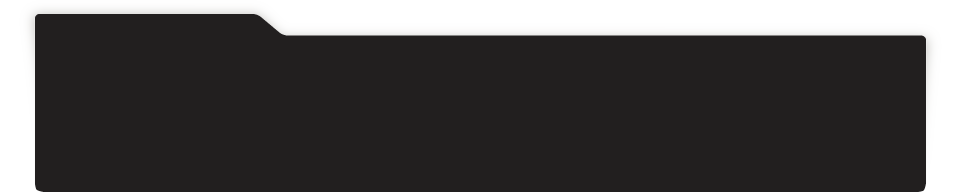
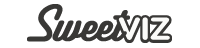
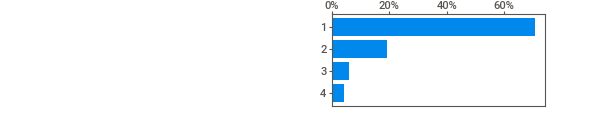
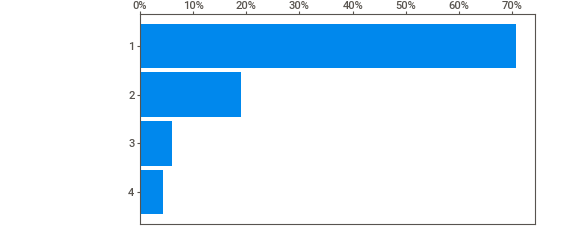
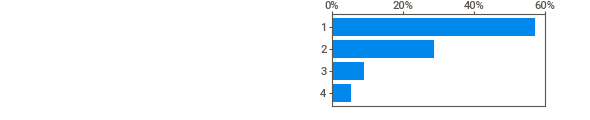
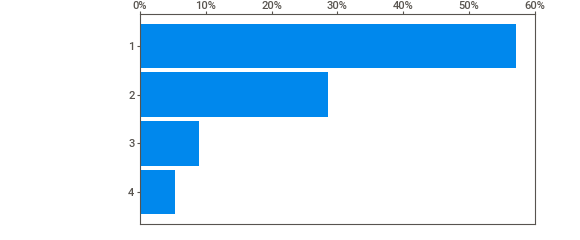
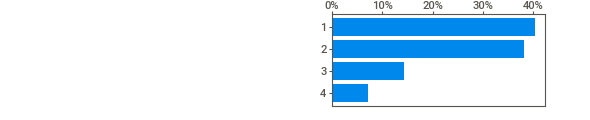
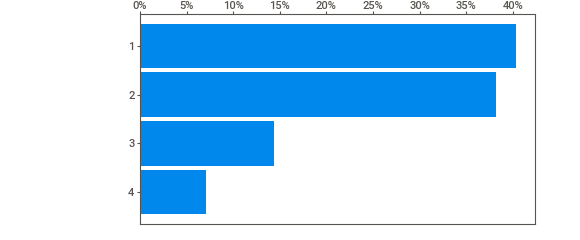
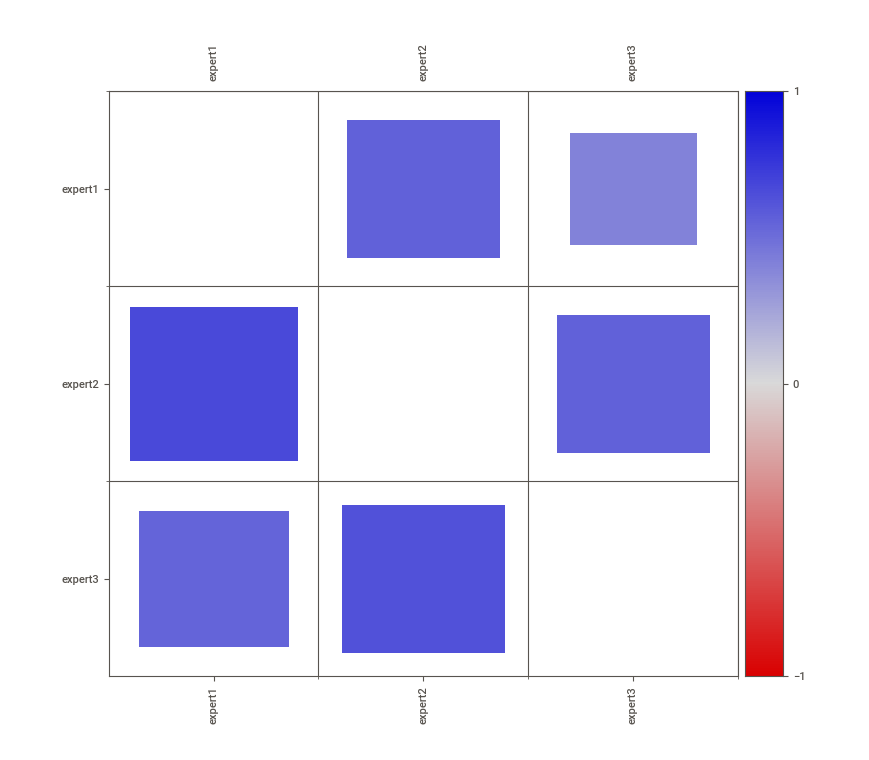
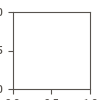

In [13]:
# вывод анализа скважин первого региона
report = sv.analyze([expert_annotations, 'expert_annotations'])
report.show_notebook(w=1500, h=500)

In [14]:
crowd_annotations.shape

(47830, 5)

In [15]:
expert_annotations.shape

(5822, 5)

In [16]:
crowd_annotations.columns

Index(['filename', 'image_id', 'text = image, %', 'text = image, count',
       'text != image, count'],
      dtype='object')

In [17]:
crowd_annotations['vote_counts'] = crowd_annotations.apply(lambda x:
                                                           x['text = image, count'] + x['text != image, count'],
                                                          axis=1)

In [18]:
crowd_annotations.head()

,filename,image_id,"text = image, %","text = image, count","text != image, count",vote_counts
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0,3
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3,3


In [19]:
crowd_annotations = crowd_annotations[crowd_annotations['vote_counts'] >= 3]

In [20]:
crowd_annotations['vote_counts'].value_counts()

3    46780
4      780
5      220
6       50
Name: vote_counts, dtype: int64

In [21]:
crowd_annotations.shape

(47830, 6)

In [22]:
crowd_annotations.drop(columns=['text = image, count', 'text != image, count', 'vote_counts'], inplace=True)

In [23]:
crowd_annotations.head()

,filename,image_id,"text = image, %"
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0


In [24]:
expert_annotations.head()

,filename,image_id,expert1,expert2,expert3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


In [25]:
def values(row, columns):
    values_list = []
    for column in columns:
        values_list.append(row[column])
    
    if len(set(values_list)) == len(values_list):
        return None
    else:
        return Counter(values_list).most_common(1)[0][0]

In [26]:
expert_annotations['experts'] = expert_annotations.apply(values,
                                                         columns=['expert1', 'expert2', 'expert3'],
                                                         axis=1)

In [27]:
expert_annotations.head()

,filename,image_id,expert1,expert2,expert3,experts
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,1.0
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,1.0
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,1.0
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,2.0
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,1.0


In [28]:
expert_annotations.isna().mean()

filename    0.000000
image_id    0.000000
expert1     0.000000
expert2     0.000000
expert3     0.000000
experts     0.021642
dtype: float64

In [29]:
expert_annotations.dropna(inplace=True)

In [30]:
expert_annotations.isna().mean()

filename    0.0
image_id    0.0
expert1     0.0
expert2     0.0
expert3     0.0
experts     0.0
dtype: float64

In [31]:
expert_annotations['experts'] = expert_annotations['experts'] / 4

In [32]:
expert_annotations.drop(columns=['expert1', 'expert2', 'expert3'], inplace=True)

In [33]:
expert_annotations.head()

,filename,image_id,experts
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.25
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.25
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.25
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.50
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.25


In [34]:
expert_annotations.experts.max()

1.0

In [35]:
expert_annotations.experts.min()

0.25

In [36]:
expert_annotations.shape

(5696, 3)

In [37]:
crowd_annotations[(crowd_annotations.filename.isin(expert_annotations.filename.unique())) & 
                  (crowd_annotations.image_id.isin(expert_annotations.image_id.unique()))]

,filename,image_id,"text = image, %"
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.000000
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.000000
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.000000
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.000000
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.000000
...,...,...,...
47825,997722733_0cb5439472.jpg,543007912_23fc735b99.jpg#2,0.000000
47826,997722733_0cb5439472.jpg,544576742_283b65fa0d.jpg#2,0.333333
47827,997722733_0cb5439472.jpg,872622575_ba1d3632cc.jpg#2,1.000000
47828,997722733_0cb5439472.jpg,888425986_e4b6c12324.jpg#2,0.000000


In [38]:
crossed_values = crowd_annotations.merge(expert_annotations, how='outer', on=['filename', 'image_id'])

In [39]:
crossed_values.shape

(51268, 4)

In [40]:
crossed_values.head(15)

,filename,image_id,"text = image, %",experts
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.000000,NaN
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.000000,NaN
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.000000,NaN
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.000000,NaN
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.000000,NaN
5,1056338697_4f7d7ce270.jpg,2204550058_2707d92338.jpg#2,0.000000,NaN
6,1056338697_4f7d7ce270.jpg,2224450291_4c133fabe8.jpg#2,0.000000,NaN
7,1056338697_4f7d7ce270.jpg,2248487950_c62d0c81a9.jpg#2,0.333333,NaN
8,1056338697_4f7d7ce270.jpg,2307118114_c258e3a47e.jpg#2,0.000000,NaN
9,1056338697_4f7d7ce270.jpg,2309860995_c2e2a0feeb.jpg#2,0.000000,NaN


In [41]:
crossed_values['text = image, %'].fillna('пропуск', inplace=True)

In [42]:
crossed_values[crossed_values['text = image, %'] == 'пропуск']

,filename,image_id,"text = image, %",experts
47830,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,пропуск,0.25
47831,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,пропуск,0.50
47832,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,пропуск,0.25
47833,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,пропуск,0.25
47834,1056338697_4f7d7ce270.jpg,3545652636_0746537307.jpg#2,пропуск,0.25
...,...,...,...,...
51263,997722733_0cb5439472.jpg,2641770481_c98465ff35.jpg#2,пропуск,0.25
51264,997722733_0cb5439472.jpg,2932740428_b15384f389.jpg#2,пропуск,0.25
51265,997722733_0cb5439472.jpg,2968182121_b3b491df85.jpg#2,пропуск,0.25
51266,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,пропуск,0.25


In [43]:
crossed_values.isna().mean()

filename           0.000000
image_id           0.000000
text = image, %    0.000000
experts            0.888898
dtype: float64

In [44]:
crossed_values['final_rate'] = crossed_values.apply(
    lambda x: x['text = image, %'] * 0.4 + x['experts'] * 0.6 if x['text = image, %'] != 'пропуск' else  x['experts'], axis=1)

In [45]:
crossed_values.tail(15)

,filename,image_id,"text = image, %",experts,final_rate
51253,96420612_feb18fc6c6.jpg,3562050678_4196a7fff3.jpg#2,пропуск,0.25,0.25
51254,968081289_cdba83ce2e.jpg,2162564553_96de62c7e6.jpg#2,пропуск,0.25,0.25
51255,968081289_cdba83ce2e.jpg,2292406847_f366350600.jpg#2,пропуск,0.25,0.25
51256,968081289_cdba83ce2e.jpg,2396025708_e4a72e2558.jpg#2,пропуск,0.50,0.50
51257,968081289_cdba83ce2e.jpg,3162045919_c2decbb69b.jpg#2,пропуск,0.25,0.25
51258,968081289_cdba83ce2e.jpg,997722733_0cb5439472.jpg#2,пропуск,0.25,0.25
51259,979383193_0a542a059d.jpg,1554713437_61b64527dd.jpg#2,пропуск,0.25,0.25
51260,979383193_0a542a059d.jpg,1962729184_6996e128e7.jpg#2,пропуск,0.50,0.50
51261,979383193_0a542a059d.jpg,3468694409_a51571d621.jpg#2,пропуск,0.25,0.25
51262,979383193_0a542a059d.jpg,3585598356_8ce815bbb9.jpg#2,пропуск,0.25,0.25


In [46]:
crossed_values['final_rate'].fillna(crossed_values['text = image, %'], inplace=True)

In [47]:
crossed_values.head(15)

,filename,image_id,"text = image, %",experts,final_rate
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,NaN,1.000000
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,NaN,0.000000
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,NaN,0.000000
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,NaN,0.000000
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,NaN,0.000000
5,1056338697_4f7d7ce270.jpg,2204550058_2707d92338.jpg#2,0.0,NaN,0.000000
6,1056338697_4f7d7ce270.jpg,2224450291_4c133fabe8.jpg#2,0.0,NaN,0.000000
7,1056338697_4f7d7ce270.jpg,2248487950_c62d0c81a9.jpg#2,0.333333,NaN,0.333333
8,1056338697_4f7d7ce270.jpg,2307118114_c258e3a47e.jpg#2,0.0,NaN,0.000000
9,1056338697_4f7d7ce270.jpg,2309860995_c2e2a0feeb.jpg#2,0.0,NaN,0.000000


In [48]:
crossed_values.isna().mean()

filename           0.000000
image_id           0.000000
text = image, %    0.000000
experts            0.888898
final_rate         0.000000
dtype: float64

In [49]:
crossed_values.drop(columns=['text = image, %', 'experts'], inplace=True)

In [50]:
crossed_values.isna().mean()

filename      0.0
image_id      0.0
final_rate    0.0
dtype: float64

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
> 

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [51]:
train_dataset.head()

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


In [52]:
exclude_words = ['child', 'adolescent', 'teenage child',
                 'adolescent child', 'ypung person', 'kid',
                 'kids', 'baby', 'juvenile', 'adolescence',
                 'young man', 'young girl', 'newborn',
                 'infant', 'toddler', 'teen', 'girl', 'boy']

In [53]:
def cleared_text(text, exclude_words):
    tokenized_text = word_tokenize(text)
    for word in exclude_words:
        if word in tokenized_text:
            return None
    return text 

In [54]:
train_dataset['final_text'] = train_dataset['query_text'].apply(lambda x: cleared_text(x, exclude_words))

In [55]:
train_dataset.shape

(5822, 4)

In [56]:
train_dataset.head(20)

,image,query_id,query_text,final_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,None
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,None
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,None
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,None
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,None
5,3030566410_393c36a6c5.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,None
6,3155451946_c0862c70cb.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,None
7,3222041930_f642f49d28.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,None
8,343218198_1ca90e0734.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,None
9,3718964174_cb2dc1615e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,None


In [57]:
train_dataset.columns = ['image', 'image_id', 'query_text', 'final_text']

In [58]:
train_dataset.dropna(inplace=True)

In [59]:
train_dataset.head(20)

,image,image_id,query_text,final_text
22,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,A man sleeps under a blanket on a city street .
23,3187395715_f2940c2b72.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,A man sleeps under a blanket on a city street .
24,463978865_c87c6ca84c.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,A man sleeps under a blanket on a city street .
25,488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,A man sleeps under a blanket on a city street .
26,534875358_6ea30d3091.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,A man sleeps under a blanket on a city street .
27,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,A woman plays with long red ribbons in an empt...,A woman plays with long red ribbons in an empt...
28,3208074567_ac44aeb3f3.jpg,3207358897_bfa61fa3c6.jpg#2,A woman plays with long red ribbons in an empt...,A woman plays with long red ribbons in an empt...
29,3251976937_20625dc2b8.jpg,3207358897_bfa61fa3c6.jpg#2,A woman plays with long red ribbons in an empt...,A woman plays with long red ribbons in an empt...
30,370713359_7560808550.jpg,3207358897_bfa61fa3c6.jpg#2,A woman plays with long red ribbons in an empt...,A woman plays with long red ribbons in an empt...
31,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,Chinese market street in the winter time .,Chinese market street in the winter time .


In [60]:
train_dataset.shape

(4639, 4)

In [61]:
crossed_values.shape

(51268, 3)

In [62]:
crossed_values.head()

,filename,image_id,final_rate
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0


In [63]:
train_dataset = train_dataset[['image_id', 'final_text']]

In [64]:
image_text_data = crossed_values.merge(train_dataset, how='inner', on='image_id')

In [65]:
image_text_data.head()

,filename,image_id,final_rate,final_text
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,"A woman is signaling is to traffic , as seen f..."
1,2182488373_df73c7cc09.jpg,1056338697_4f7d7ce270.jpg#2,0.0,"A woman is signaling is to traffic , as seen f..."
2,2594042571_2e4666507e.jpg,1056338697_4f7d7ce270.jpg#2,0.0,"A woman is signaling is to traffic , as seen f..."
3,2843695880_eeea6c67db.jpg,1056338697_4f7d7ce270.jpg#2,0.0,"A woman is signaling is to traffic , as seen f..."
4,2892995070_39f3c9a56e.jpg,1056338697_4f7d7ce270.jpg#2,0.0,"A woman is signaling is to traffic , as seen f..."


In [66]:
image_text_data.dropna(subset=['final_text'])

,filename,image_id,final_rate,final_text
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.00,"A woman is signaling is to traffic , as seen f..."
1,2182488373_df73c7cc09.jpg,1056338697_4f7d7ce270.jpg#2,0.00,"A woman is signaling is to traffic , as seen f..."
2,2594042571_2e4666507e.jpg,1056338697_4f7d7ce270.jpg#2,0.00,"A woman is signaling is to traffic , as seen f..."
3,2843695880_eeea6c67db.jpg,1056338697_4f7d7ce270.jpg#2,0.00,"A woman is signaling is to traffic , as seen f..."
4,2892995070_39f3c9a56e.jpg,1056338697_4f7d7ce270.jpg#2,0.00,"A woman is signaling is to traffic , as seen f..."
...,...,...,...,...
258594,3745451546_fc8ec70cbd.jpg,3108732084_565b423162.jpg#2,0.25,a snowboarder
258595,447111935_5af98563e3.jpg,3108732084_565b423162.jpg#2,0.25,a snowboarder
258596,447111935_5af98563e3.jpg,3108732084_565b423162.jpg#2,0.25,a snowboarder
258597,447111935_5af98563e3.jpg,3108732084_565b423162.jpg#2,0.25,a snowboarder


In [67]:
image_text_data.drop_duplicates(inplace=True)

In [68]:
image_text_data.shape

(39746, 4)

In [69]:
image_text_data.head()

,filename,image_id,final_rate,final_text
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,"A woman is signaling is to traffic , as seen f..."
1,2182488373_df73c7cc09.jpg,1056338697_4f7d7ce270.jpg#2,0.0,"A woman is signaling is to traffic , as seen f..."
2,2594042571_2e4666507e.jpg,1056338697_4f7d7ce270.jpg#2,0.0,"A woman is signaling is to traffic , as seen f..."
3,2843695880_eeea6c67db.jpg,1056338697_4f7d7ce270.jpg#2,0.0,"A woman is signaling is to traffic , as seen f..."
4,2892995070_39f3c9a56e.jpg,1056338697_4f7d7ce270.jpg#2,0.0,"A woman is signaling is to traffic , as seen f..."


## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [70]:
resnet = models.resnet50(pretrained=True) # загружаем претренированную модель
for param in resnet.parameters():  # замораживаем веса
    param.requires_grad_(False) 

/Users/razanovaekaterinaandreevna/PycharmProjects/proj/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/razanovaekaterinaandreevna/PycharmProjects/proj/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/razanovaekaterinaandreevna/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [71]:
modules = list(resnet.children())[:-2]
resnet = nn.Sequential(*modules)
resnet.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [72]:
norm = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    norm,
]) 

In [73]:
test_images_path = Path('/Users/razanovaekaterinaandreevna/PycharmProjects/proj/datasets/test_images')
test_images_list = [str(dataset) for dataset in test_images_path.rglob('*.jpg')]

In [74]:
train_images_path = Path('/Users/razanovaekaterinaandreevna/PycharmProjects/proj/datasets/train_images')
train_images_list = [str(dataset) for dataset in train_images_path.rglob('*.jpg')]

In [75]:
len(train_images_list)

1000

In [76]:
train_tensors = []
for image in tqdm(train_images_list):
    img = Image.open(image).convert('RGB') 
    image_tensor = preprocess(img)
    output_tensor = resnet(image_tensor.unsqueeze(0)).flatten()
    train_tensors.append(output_tensor)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:29<00:00,  6.71it/s]


In [77]:
images_list = []
for image in train_images_list:
    images_list.append(image.split('/')[-1])

In [78]:
train_image_tensor_data = pd.DataFrame({'filename': images_list,
                                        'tensor': train_tensors})

In [79]:
train_image_tensor_data

,filename,tensor
0,2869491449_1041485a6b.jpg,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
1,2924259848_effb4dcb82.jpg,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
2,2300168895_a9b83e16fc.jpg,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
3,3530843182_35af2c821c.jpg,"[tensor(0.), tensor(0.0507), tensor(0.), tenso..."
4,3439382048_d2e23b2b4c.jpg,"[tensor(0.), tensor(0.2009), tensor(0.), tenso..."
...,...,...
995,801607443_f15956d1ce.jpg,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
996,3497224764_6e17544e0d.jpg,"[tensor(0.2279), tensor(0.3189), tensor(0.5449..."
997,150387174_24825cf871.jpg,"[tensor(0.), tensor(0.), tensor(0.3642), tenso..."
998,3694093650_547259731e.jpg,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."


In [80]:
crossed_values.head()

,filename,image_id,final_rate
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0


In [81]:
crossed_values.shape

(51268, 3)

In [82]:
data_image_tensor = crossed_values.merge(train_image_tensor_data, how='left', on='filename')

In [83]:
data_image_tensor.head()

,filename,image_id,final_rate,tensor
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."


In [84]:
data_image_tensor.to_csv('/Users/razanovaekaterinaandreevna/PycharmProjects/proj/data_image_tensor.csv', index=False)

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

## 8. Выводы

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Проверены экспертные оценки и краудсорсинговые оценки
- [x]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [x]  Изображения векторизованы
- [ ]  Текстовые запросы векторизованы
- [ ]  Данные корректно разбиты на тренировочную и тестовую выборки
- [ ]  Предложена метрика качества работы модели
- [ ]  Предложена модель схожести изображений и текстового запроса
- [ ]  Модель обучена
- [ ]  По итогам обучения модели сделаны выводы
- [ ]  Проведено тестирование работы модели
- [ ]  По итогам тестирования визуально сравнили качество поиска